In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from _config import *

cluster_file = r'C:\Users\kscar\Documents\GitHub\02807_Project\output\season_clustering\KMeans_clustering_season_1_seasonYear_2015.csv'
station_mapping = pd.read_csv(os.getenv('STATION_MAPPING'), dtype=str)
shape_file = Path(os.getenv('SHAPE_FILE'))

# Loading catchment data shape file .shp

In [3]:
all_catchments_gdf = gpd.read_file(shape_file)
print(all_catchments_gdf.shape)
print(all_catchments_gdf.columns)
all_catchments_gdf.head()

(3447, 4)
Index(['Id15_v30', 'area', 'hypeid', 'geometry'], dtype='object')


,Id15_v30,area,hypeid,geometry
0,11100001,3.222040e+07,1,"POLYGON Z ((477487.121 6325222.212 0, 477543.1..."
1,11100003,3.057747e+07,2,"POLYGON Z ((474003.147 6316165.657 0, 473870.1..."
2,11100004,1.825017e+07,3,"MULTIPOLYGON Z (((468046.994 6317094.258 0, 46..."
3,11100005,1.534746e+07,4,"POLYGON Z ((466052.174 6318307.21 0, 466150.17..."
4,11100006,1.524262e+07,5,"POLYGON Z ((476077.142 6328208.222 0, 476062.1..."


# Loading clustering file
Assumes file with format:
```csv
CID,Cluster
10000009,0
10000010,1
...
```

In [4]:
cluster_mapping = pd.read_csv(cluster_file, dtype=str)
cluster_mapping.columns = ['id', 'cluster']
cluster_mapping.head()

,id,cluster
0,10000009,0
1,10000010,0
2,10000011,2
3,10000014,0
4,10000016,2


## Map to Id15_v30

In [5]:
new_column = []
for catchment in cluster_mapping['id'].values:
    new_column.append(np.int64(station_mapping[station_mapping["obsstednr"] == catchment]["Id15_v30"].values[0]))

cluster_mapping['Id15_v30'] = new_column
cluster_mapping.drop(columns=['id'], inplace=True)
display(cluster_mapping.head())

,cluster,Id15_v30
0,0,37240441
1,0,37210639
2,2,37150512
3,0,37230017
4,2,37220017


## Filter to available catchments

In [6]:
import numpy as np

# filter out gauged catchments
idxs = all_catchments_gdf['Id15_v30'].isin([np.int64(x) for x in cluster_mapping['Id15_v30'].values])
gauged_catchments_gdf = all_catchments_gdf[idxs]
ungauged_catchments_gdf = all_catchments_gdf[idxs == False]
print(gauged_catchments_gdf.shape)
print(ungauged_catchments_gdf.shape)

(267, 4)
(3180, 4)


## Merge shape file and dataframe

In [7]:
merged_gdf = gauged_catchments_gdf.merge(cluster_mapping, on='Id15_v30')
merged_gdf['area'] = merged_gdf.geometry.area
print(merged_gdf.shape)
merged_gdf.head()

(267, 5)


,Id15_v30,area,hypeid,geometry,cluster
0,12430456,1.093603e+09,71,"POLYGON Z ((476203.448 6227766.813 0, 476115.4...",1
1,12430590,2.292267e+07,76,"POLYGON Z ((472282.451 6235539.727 0, 472263.4...",0
2,12430591,1.901684e+07,77,"POLYGON Z ((474461.385 6248572.618 0, 474435.3...",2
3,12430666,8.308295e+07,81,"POLYGON Z ((476332.447 6227749.814 0, 476313.4...",1
4,12430747,4.931502e+08,100,"POLYGON Z ((500741.273 6217364.991 0, 500685.2...",1


# Plot by cluster (assumes `cluster` column)

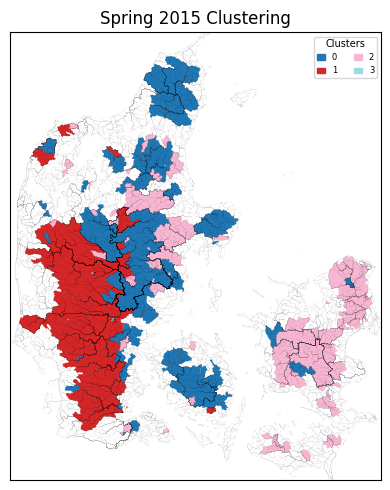

In [8]:
cmap = "tab20"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot without automatic legend
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="cluster",
    figsize=(25, 15),
    ax=ax,
    legend=False,  # turn off auto legend
    cmap=cmap
)

ax.set_title(f"Spring 2015 Clustering")

# Add Denmark boundary
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax, color='black', linewidth=0.02)

# Axis settings
ax.set_xlim(left=440000, right=730000)
ax.set_ylim(top=6.4e6, bottom=6.05e6)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --------------------------------------------------------
#  CUSTOM LEGEND (3 columns, small size, upper-right)
# --------------------------------------------------------
import matplotlib as mpl
import matplotlib.patches as mpatches

# Treat cluster as categorical so we have a stable order
cluster_cat = merged_gdf["cluster"].astype("category")
clusters_ordered = list(cluster_cat.cat.categories)  # ordered categories

# New style colormap access (no deprecation warning)
cmap_obj = mpl.colormaps[cmap]  # or mpl.colormaps.get_cmap(cmap)

n_clusters = len(clusters_ordered)

handles = []
for i, c in enumerate(clusters_ordered):
    # Map category index to [0, 1] range for the colormap
    if n_clusters == 1:
        t = 0.5
    else:
        t = i / (n_clusters - 1)
    color = cmap_obj(t)

    handles.append(
        mpatches.Patch(
            color=color,
            label=str(c)
        )
    )

ax.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    bbox_to_anchor=(1, 1),
    ncol=2,  # ⭐ three columns
    fontsize=6,  # small text
    title_fontsize=7,
    frameon=True,
    borderpad=0.3,
    handlelength=1.0
)

plt.tight_layout()
plt.savefig(
    str(Path(cluster_file).parent / Path(cluster_file).stem) + '.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

---
# Plot the catchment area plot for data section.

C:\Users\kscar\AppData\Local\Temp\ipykernel_26096\3937956479.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


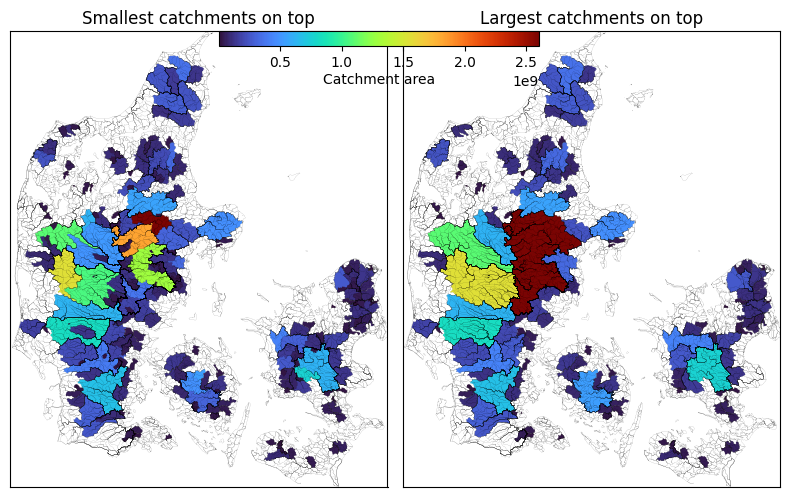

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Define common normalization and colormap
vmin = merged_gdf["area"].min()
vmax = merged_gdf["area"].max()
cmap = "turbo"

# Plot the maps using a continuous color scale
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="area", ax=ax[0], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)
merged_gdf.sort_values(by="area", ascending=True).plot(
    column="area", ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)

# Titles
ax[0].set_title("Smallest catchments on top")
ax[1].set_title("Largest catchments on top")

# Remove y-axis from second plot
ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].tick_params(left=False)

# Add Denmark boundary outlines
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax[0], color='black', linewidth=0.05)
denmark_boundary.plot(ax=ax[1], color='black', linewidth=0.05)

# Axis settings
ax[0].set_xlim(left=440000, right=730000)
ax[0].set_ylim(top=6.4e6, bottom=6.05e6)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].set_xlim(left=440000, right=730000)
ax[1].set_ylim(top=6.4e6, bottom=6.05e6)
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a shared colorbar on the right
# Add a shared colorbar at the top center
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []

# Create a new axis for the colorbar spanning both subplots
cbar_ax = fig.add_axes([0.28, 0.927, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Catchment area", labelpad=2)


plt.tight_layout()
plt.savefig('gauged_catchments_area.png', dpi=300)
plt.show()

# Summer 2015

In [10]:
cluster_file = r'C:\Users\kscar\Documents\GitHub\02807_Project\output\season_clustering\KMeans_clustering_season_2_seasonYear_2015.csv'
station_mapping = pd.read_csv(os.getenv('STATION_MAPPING'), dtype=str)
shape_file = Path(os.getenv('SHAPE_FILE'))

In [11]:
all_catchments_gdf = gpd.read_file(shape_file)
print(all_catchments_gdf.shape)
print(all_catchments_gdf.columns)
all_catchments_gdf.head()

(3447, 4)
Index(['Id15_v30', 'area', 'hypeid', 'geometry'], dtype='object')


,Id15_v30,area,hypeid,geometry
0,11100001,3.222040e+07,1,"POLYGON Z ((477487.121 6325222.212 0, 477543.1..."
1,11100003,3.057747e+07,2,"POLYGON Z ((474003.147 6316165.657 0, 473870.1..."
2,11100004,1.825017e+07,3,"MULTIPOLYGON Z (((468046.994 6317094.258 0, 46..."
3,11100005,1.534746e+07,4,"POLYGON Z ((466052.174 6318307.21 0, 466150.17..."
4,11100006,1.524262e+07,5,"POLYGON Z ((476077.142 6328208.222 0, 476062.1..."


In [12]:
cluster_mapping = pd.read_csv(cluster_file, dtype=str)
cluster_mapping.columns = ['id', 'cluster']
cluster_mapping.head()

,id,cluster
0,10000009,1
1,10000010,0
2,10000011,0
3,10000014,1
4,10000016,0


In [13]:
new_column = []
for catchment in cluster_mapping['id'].values:
    new_column.append(np.int64(station_mapping[station_mapping["obsstednr"] == catchment]["Id15_v30"].values[0]))

cluster_mapping['Id15_v30'] = new_column
cluster_mapping.drop(columns=['id'], inplace=True)
display(cluster_mapping.head())

,cluster,Id15_v30
0,1,37240441
1,0,37210639
2,0,37150512
3,1,37230017
4,0,37220017


In [14]:
import numpy as np

# filter out gauged catchments
idxs = all_catchments_gdf['Id15_v30'].isin([np.int64(x) for x in cluster_mapping['Id15_v30'].values])
gauged_catchments_gdf = all_catchments_gdf[idxs]
ungauged_catchments_gdf = all_catchments_gdf[idxs == False]
print(gauged_catchments_gdf.shape)
print(ungauged_catchments_gdf.shape)

(265, 4)
(3182, 4)


In [15]:
merged_gdf = gauged_catchments_gdf.merge(cluster_mapping, on='Id15_v30')
merged_gdf['area'] = merged_gdf.geometry.area
print(merged_gdf.shape)
merged_gdf.head()

(265, 5)


,Id15_v30,area,hypeid,geometry,cluster
0,12430456,1.093603e+09,71,"POLYGON Z ((476203.448 6227766.813 0, 476115.4...",1
1,12430590,2.292267e+07,76,"POLYGON Z ((472282.451 6235539.727 0, 472263.4...",1
2,12430591,1.901684e+07,77,"POLYGON Z ((474461.385 6248572.618 0, 474435.3...",0
3,12430666,8.308295e+07,81,"POLYGON Z ((476332.447 6227749.814 0, 476313.4...",1
4,12430747,4.931502e+08,100,"POLYGON Z ((500741.273 6217364.991 0, 500685.2...",1


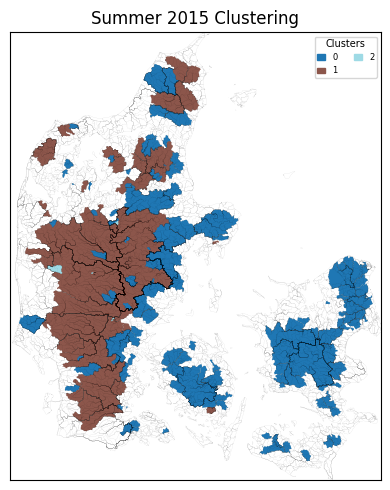

In [16]:
cmap = "tab20"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot without automatic legend
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="cluster",
    figsize=(25, 15),
    ax=ax,
    legend=False,  # turn off auto legend
    cmap=cmap
)

ax.set_title(f"Summer 2015 Clustering")

# Add Denmark boundary
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax, color='black', linewidth=0.02)

# Axis settings
ax.set_xlim(left=440000, right=730000)
ax.set_ylim(top=6.4e6, bottom=6.05e6)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --------------------------------------------------------
#  CUSTOM LEGEND (3 columns, small size, upper-right)
# --------------------------------------------------------
import matplotlib as mpl
import matplotlib.patches as mpatches

# Treat cluster as categorical so we have a stable order
cluster_cat = merged_gdf["cluster"].astype("category")
clusters_ordered = list(cluster_cat.cat.categories)  # ordered categories

# New style colormap access (no deprecation warning)
cmap_obj = mpl.colormaps[cmap]  # or mpl.colormaps.get_cmap(cmap)

n_clusters = len(clusters_ordered)

handles = []
for i, c in enumerate(clusters_ordered):
    # Map category index to [0, 1] range for the colormap
    if n_clusters == 1:
        t = 0.5
    else:
        t = i / (n_clusters - 1)
    color = cmap_obj(t)

    handles.append(
        mpatches.Patch(
            color=color,
            label=str(c)
        )
    )

ax.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    bbox_to_anchor=(1, 1),
    ncol=2,  # ⭐ three columns
    fontsize=6,  # small text
    title_fontsize=7,
    frameon=True,
    borderpad=0.3,
    handlelength=1.0
)

plt.tight_layout()
plt.savefig(
    str(Path(cluster_file).parent / Path(cluster_file).stem) + '.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

C:\Users\kscar\AppData\Local\Temp\ipykernel_26096\3937956479.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


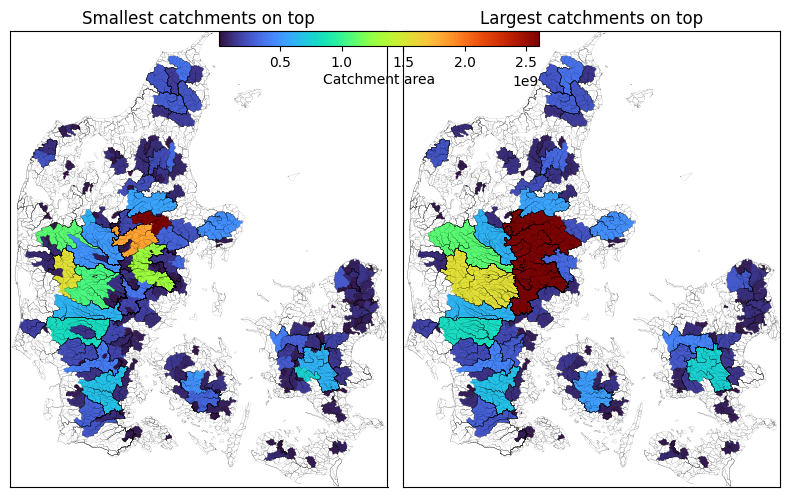

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Define common normalization and colormap
vmin = merged_gdf["area"].min()
vmax = merged_gdf["area"].max()
cmap = "turbo"

# Plot the maps using a continuous color scale
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="area", ax=ax[0], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)
merged_gdf.sort_values(by="area", ascending=True).plot(
    column="area", ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)

# Titles
ax[0].set_title("Smallest catchments on top")
ax[1].set_title("Largest catchments on top")

# Remove y-axis from second plot
ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].tick_params(left=False)

# Add Denmark boundary outlines
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax[0], color='black', linewidth=0.05)
denmark_boundary.plot(ax=ax[1], color='black', linewidth=0.05)

# Axis settings
ax[0].set_xlim(left=440000, right=730000)
ax[0].set_ylim(top=6.4e6, bottom=6.05e6)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].set_xlim(left=440000, right=730000)
ax[1].set_ylim(top=6.4e6, bottom=6.05e6)
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a shared colorbar on the right
# Add a shared colorbar at the top center
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []

# Create a new axis for the colorbar spanning both subplots
cbar_ax = fig.add_axes([0.28, 0.927, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Catchment area", labelpad=2)


plt.tight_layout()
plt.savefig('gauged_catchments_area.png', dpi=300)
plt.show()

# Fall 2015

In [18]:
cluster_file = r'C:\Users\kscar\Documents\GitHub\02807_Project\output\season_clustering\KMeans_clustering_season_3_seasonYear_2015.csv'
station_mapping = pd.read_csv(os.getenv('STATION_MAPPING'), dtype=str)
shape_file = Path(os.getenv('SHAPE_FILE'))

In [19]:
all_catchments_gdf = gpd.read_file(shape_file)
print(all_catchments_gdf.shape)
print(all_catchments_gdf.columns)
all_catchments_gdf.head()

(3447, 4)
Index(['Id15_v30', 'area', 'hypeid', 'geometry'], dtype='object')


,Id15_v30,area,hypeid,geometry
0,11100001,3.222040e+07,1,"POLYGON Z ((477487.121 6325222.212 0, 477543.1..."
1,11100003,3.057747e+07,2,"POLYGON Z ((474003.147 6316165.657 0, 473870.1..."
2,11100004,1.825017e+07,3,"MULTIPOLYGON Z (((468046.994 6317094.258 0, 46..."
3,11100005,1.534746e+07,4,"POLYGON Z ((466052.174 6318307.21 0, 466150.17..."
4,11100006,1.524262e+07,5,"POLYGON Z ((476077.142 6328208.222 0, 476062.1..."


In [20]:
cluster_mapping = pd.read_csv(cluster_file, dtype=str)
cluster_mapping.columns = ['id', 'cluster']
cluster_mapping.head()

,id,cluster
0,10000009,0
1,10000010,1
2,10000011,1
3,10000014,0
4,10000016,1


In [21]:
new_column = []
for catchment in cluster_mapping['id'].values:
    new_column.append(np.int64(station_mapping[station_mapping["obsstednr"] == catchment]["Id15_v30"].values[0]))

cluster_mapping['Id15_v30'] = new_column
cluster_mapping.drop(columns=['id'], inplace=True)
display(cluster_mapping.head())

,cluster,Id15_v30
0,0,37240441
1,1,37210639
2,1,37150512
3,0,37230017
4,1,37220017


In [22]:
import numpy as np

# filter out gauged catchments
idxs = all_catchments_gdf['Id15_v30'].isin([np.int64(x) for x in cluster_mapping['Id15_v30'].values])
gauged_catchments_gdf = all_catchments_gdf[idxs]
ungauged_catchments_gdf = all_catchments_gdf[idxs == False]
print(gauged_catchments_gdf.shape)
print(ungauged_catchments_gdf.shape)

(265, 4)
(3182, 4)


In [23]:
merged_gdf = gauged_catchments_gdf.merge(cluster_mapping, on='Id15_v30')
merged_gdf['area'] = merged_gdf.geometry.area
print(merged_gdf.shape)
merged_gdf.head()

(265, 5)


,Id15_v30,area,hypeid,geometry,cluster
0,12430456,1.093603e+09,71,"POLYGON Z ((476203.448 6227766.813 0, 476115.4...",0
1,12430590,2.292267e+07,76,"POLYGON Z ((472282.451 6235539.727 0, 472263.4...",0
2,12430591,1.901684e+07,77,"POLYGON Z ((474461.385 6248572.618 0, 474435.3...",1
3,12430666,8.308295e+07,81,"POLYGON Z ((476332.447 6227749.814 0, 476313.4...",0
4,12430747,4.931502e+08,100,"POLYGON Z ((500741.273 6217364.991 0, 500685.2...",0


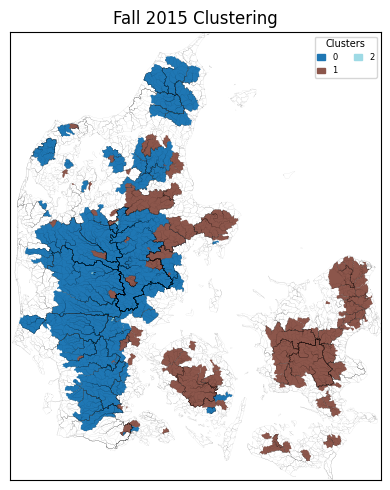

In [24]:
cmap = "tab20"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot without automatic legend
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="cluster",
    figsize=(25, 15),
    ax=ax,
    legend=False,  # turn off auto legend
    cmap=cmap
)

ax.set_title(f"Fall 2015 Clustering")

# Add Denmark boundary
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax, color='black', linewidth=0.02)

# Axis settings
ax.set_xlim(left=440000, right=730000)
ax.set_ylim(top=6.4e6, bottom=6.05e6)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --------------------------------------------------------
#  CUSTOM LEGEND (3 columns, small size, upper-right)
# --------------------------------------------------------
import matplotlib as mpl
import matplotlib.patches as mpatches

# Treat cluster as categorical so we have a stable order
cluster_cat = merged_gdf["cluster"].astype("category")
clusters_ordered = list(cluster_cat.cat.categories)  # ordered categories

# New style colormap access (no deprecation warning)
cmap_obj = mpl.colormaps[cmap]  # or mpl.colormaps.get_cmap(cmap)

n_clusters = len(clusters_ordered)

handles = []
for i, c in enumerate(clusters_ordered):
    # Map category index to [0, 1] range for the colormap
    if n_clusters == 1:
        t = 0.5
    else:
        t = i / (n_clusters - 1)
    color = cmap_obj(t)

    handles.append(
        mpatches.Patch(
            color=color,
            label=str(c)
        )
    )

ax.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    bbox_to_anchor=(1, 1),
    ncol=2,  # ⭐ three columns
    fontsize=6,  # small text
    title_fontsize=7,
    frameon=True,
    borderpad=0.3,
    handlelength=1.0
)

plt.tight_layout()
plt.savefig(
    str(Path(cluster_file).parent / Path(cluster_file).stem) + '.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

C:\Users\kscar\AppData\Local\Temp\ipykernel_26096\3937956479.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


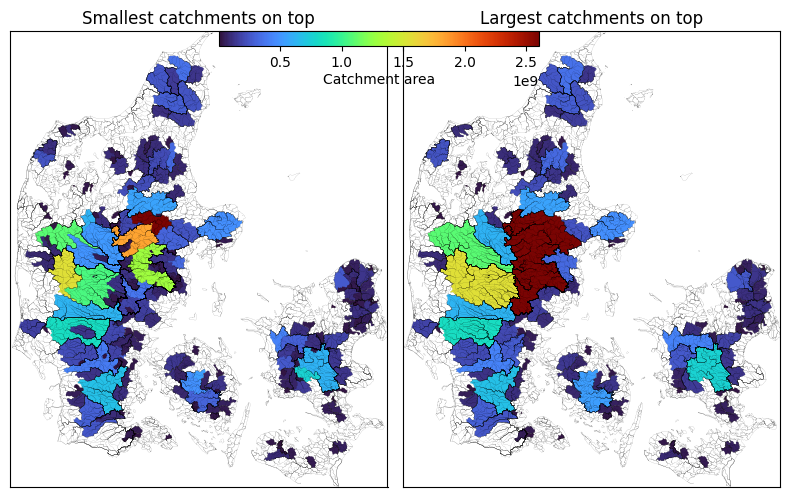

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Define common normalization and colormap
vmin = merged_gdf["area"].min()
vmax = merged_gdf["area"].max()
cmap = "turbo"

# Plot the maps using a continuous color scale
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="area", ax=ax[0], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)
merged_gdf.sort_values(by="area", ascending=True).plot(
    column="area", ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)

# Titles
ax[0].set_title("Smallest catchments on top")
ax[1].set_title("Largest catchments on top")

# Remove y-axis from second plot
ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].tick_params(left=False)

# Add Denmark boundary outlines
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax[0], color='black', linewidth=0.05)
denmark_boundary.plot(ax=ax[1], color='black', linewidth=0.05)

# Axis settings
ax[0].set_xlim(left=440000, right=730000)
ax[0].set_ylim(top=6.4e6, bottom=6.05e6)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].set_xlim(left=440000, right=730000)
ax[1].set_ylim(top=6.4e6, bottom=6.05e6)
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a shared colorbar on the right
# Add a shared colorbar at the top center
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []

# Create a new axis for the colorbar spanning both subplots
cbar_ax = fig.add_axes([0.28, 0.927, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Catchment area", labelpad=2)


plt.tight_layout()
plt.savefig('gauged_catchments_area.png', dpi=300)
plt.show()

# Winter

In [26]:
cluster_file = r'C:\Users\kscar\Documents\GitHub\02807_Project\output\season_clustering\KMeans_clustering_season_3_seasonYear_2015.csv'
station_mapping = pd.read_csv(os.getenv('STATION_MAPPING'), dtype=str)
shape_file = Path(os.getenv('SHAPE_FILE'))

In [27]:
all_catchments_gdf = gpd.read_file(shape_file)
print(all_catchments_gdf.shape)
print(all_catchments_gdf.columns)
all_catchments_gdf.head()

(3447, 4)
Index(['Id15_v30', 'area', 'hypeid', 'geometry'], dtype='object')


,Id15_v30,area,hypeid,geometry
0,11100001,3.222040e+07,1,"POLYGON Z ((477487.121 6325222.212 0, 477543.1..."
1,11100003,3.057747e+07,2,"POLYGON Z ((474003.147 6316165.657 0, 473870.1..."
2,11100004,1.825017e+07,3,"MULTIPOLYGON Z (((468046.994 6317094.258 0, 46..."
3,11100005,1.534746e+07,4,"POLYGON Z ((466052.174 6318307.21 0, 466150.17..."
4,11100006,1.524262e+07,5,"POLYGON Z ((476077.142 6328208.222 0, 476062.1..."


In [28]:
cluster_mapping = pd.read_csv(cluster_file, dtype=str)
cluster_mapping.columns = ['id', 'cluster']
cluster_mapping.head()

,id,cluster
0,10000009,0
1,10000010,1
2,10000011,1
3,10000014,0
4,10000016,1


In [29]:
new_column = []
for catchment in cluster_mapping['id'].values:
    new_column.append(np.int64(station_mapping[station_mapping["obsstednr"] == catchment]["Id15_v30"].values[0]))

cluster_mapping['Id15_v30'] = new_column
cluster_mapping.drop(columns=['id'], inplace=True)
display(cluster_mapping.head())

,cluster,Id15_v30
0,0,37240441
1,1,37210639
2,1,37150512
3,0,37230017
4,1,37220017


In [30]:
import numpy as np

# filter out gauged catchments
idxs = all_catchments_gdf['Id15_v30'].isin([np.int64(x) for x in cluster_mapping['Id15_v30'].values])
gauged_catchments_gdf = all_catchments_gdf[idxs]
ungauged_catchments_gdf = all_catchments_gdf[idxs == False]
print(gauged_catchments_gdf.shape)
print(ungauged_catchments_gdf.shape)

(265, 4)
(3182, 4)


In [31]:
merged_gdf = gauged_catchments_gdf.merge(cluster_mapping, on='Id15_v30')
merged_gdf['area'] = merged_gdf.geometry.area
print(merged_gdf.shape)
merged_gdf.head()

(265, 5)


,Id15_v30,area,hypeid,geometry,cluster
0,12430456,1.093603e+09,71,"POLYGON Z ((476203.448 6227766.813 0, 476115.4...",0
1,12430590,2.292267e+07,76,"POLYGON Z ((472282.451 6235539.727 0, 472263.4...",0
2,12430591,1.901684e+07,77,"POLYGON Z ((474461.385 6248572.618 0, 474435.3...",1
3,12430666,8.308295e+07,81,"POLYGON Z ((476332.447 6227749.814 0, 476313.4...",0
4,12430747,4.931502e+08,100,"POLYGON Z ((500741.273 6217364.991 0, 500685.2...",0


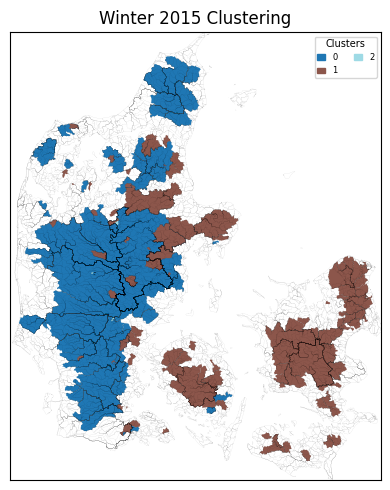

In [32]:
cmap = "tab20"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot without automatic legend
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="cluster",
    figsize=(25, 15),
    ax=ax,
    legend=False,  # turn off auto legend
    cmap=cmap
)

ax.set_title(f"Winter 2015 Clustering")

# Add Denmark boundary
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax, color='black', linewidth=0.02)

# Axis settings
ax.set_xlim(left=440000, right=730000)
ax.set_ylim(top=6.4e6, bottom=6.05e6)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --------------------------------------------------------
#  CUSTOM LEGEND (3 columns, small size, upper-right)
# --------------------------------------------------------
import matplotlib as mpl
import matplotlib.patches as mpatches

# Treat cluster as categorical so we have a stable order
cluster_cat = merged_gdf["cluster"].astype("category")
clusters_ordered = list(cluster_cat.cat.categories)  # ordered categories

# New style colormap access (no deprecation warning)
cmap_obj = mpl.colormaps[cmap]  # or mpl.colormaps.get_cmap(cmap)

n_clusters = len(clusters_ordered)

handles = []
for i, c in enumerate(clusters_ordered):
    # Map category index to [0, 1] range for the colormap
    if n_clusters == 1:
        t = 0.5
    else:
        t = i / (n_clusters - 1)
    color = cmap_obj(t)

    handles.append(
        mpatches.Patch(
            color=color,
            label=str(c)
        )
    )

ax.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    bbox_to_anchor=(1, 1),
    ncol=2,  # ⭐ three columns
    fontsize=6,  # small text
    title_fontsize=7,
    frameon=True,
    borderpad=0.3,
    handlelength=1.0
)

plt.tight_layout()
plt.savefig(
    str(Path(cluster_file).parent / Path(cluster_file).stem) + '.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

C:\Users\kscar\AppData\Local\Temp\ipykernel_26096\3937956479.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


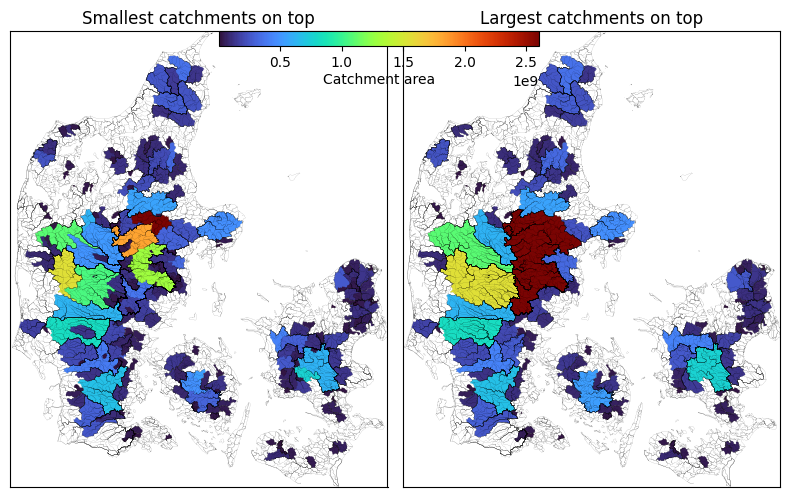

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Define common normalization and colormap
vmin = merged_gdf["area"].min()
vmax = merged_gdf["area"].max()
cmap = "turbo"

# Plot the maps using a continuous color scale
merged_gdf.sort_values(by="area", ascending=False).plot(
    column="area", ax=ax[0], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)
merged_gdf.sort_values(by="area", ascending=True).plot(
    column="area", ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False
)

# Titles
ax[0].set_title("Smallest catchments on top")
ax[1].set_title("Largest catchments on top")

# Remove y-axis from second plot
ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].tick_params(left=False)

# Add Denmark boundary outlines
denmark_boundary = all_catchments_gdf.boundary
denmark_boundary.plot(ax=ax[0], color='black', linewidth=0.05)
denmark_boundary.plot(ax=ax[1], color='black', linewidth=0.05)

# Axis settings
ax[0].set_xlim(left=440000, right=730000)
ax[0].set_ylim(top=6.4e6, bottom=6.05e6)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].set_xlim(left=440000, right=730000)
ax[1].set_ylim(top=6.4e6, bottom=6.05e6)
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a shared colorbar on the right
# Add a shared colorbar at the top center
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []

# Create a new axis for the colorbar spanning both subplots
cbar_ax = fig.add_axes([0.28, 0.927, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Catchment area", labelpad=2)


plt.tight_layout()
plt.savefig('gauged_catchments_area.png', dpi=300)
plt.show()

In [34]:



# from pathlib import Path
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from matplotlib.cm import get_cmap

# # Specify the exact path to the folder containing CSV files
# folder_path = Path(r'C:\Users\kscar\Documents\GitHub\02807_Project\output\season_clustering')

# multi_year_plotting = True
# if multi_year_plotting:
#     print("Starting multi-year plotting...")
#     # Create output folder for plots
#     output_season_clustering_dir = folder_path  
#     output_season_clustering_dir.mkdir(exist_ok=True)
#     print(f"Output directory: {output_season_clustering_dir}")

#     # Get all CSV files in the folder
#     csv_files = sorted(folder_path.glob('*.csv'))
#     print(f"Found {len(csv_files)} CSV files to process\n")

#     # Pre-compute Denmark boundary once (this can be slow)
#     print("Computing Denmark boundary (this may take a moment)...")
#     denmark_boundary = all_catchments_gdf.boundary
#     print("Denmark boundary computed.\n")

#     # FIRST PASS: Collect all unique cluster IDs across all years to ensure consistent color mapping
#     print("First pass: Collecting all unique cluster IDs across all years...")
#     all_cluster_ids = set()
#     for csv_file in csv_files:
#         cluster_mapping = pd.read_csv(csv_file, dtype=str)
#         cluster_mapping.columns = ['id', 'cluster']
#         all_cluster_ids.update(cluster_mapping['cluster'].unique())

#     # Sort cluster IDs (as integers) and create consistent color mapping
#     # Exclude "other" from the sorted list, we'll add it with a distinct color
#     sorted_clusters = sorted([int(c) for c in all_cluster_ids if c != 'other'], reverse=False)
#     print(f"Found {len(sorted_clusters)} unique cluster IDs: {sorted_clusters[:10]}...")

#     # Create color mapping: use Set1 colormap for regular clusters, distinct gray for "other"
#     # Get Set1 colormap colors
#     set1_cmap = get_cmap('Set1')
#     num_colors = 9  # Set1 has 9 distinct colors
#     color_map = {}

#     # Assign colors to regular clusters
#     for i, cluster_id in enumerate(sorted_clusters):
#         color_idx = i % num_colors
#         color_map[str(cluster_id)] = set1_cmap(color_idx)

#     # Assign distinct color for "other" (gray)
#     color_map['other'] = '#808080'  # Gray color

#     print(f"Created color mapping for {len(color_map)} categories (including 'other')\n")

#     # SECOND PASS: Process each CSV file and plot
#     print("Second pass: Processing and plotting files...\n")
#     for idx, csv_file in enumerate(csv_files, 1):
#         # Get filename without extension for naming
#         file_stem = csv_file.stem

#         print(f"[{idx}/{len(csv_files)}] Processing: {csv_file.name}...")

#         # Load cluster mapping
#         cluster_mapping = pd.read_csv(csv_file, dtype=str)
#         cluster_mapping.columns = ['id', 'cluster']
#         print(f"  Loaded {len(cluster_mapping)} catchments from file")

#         # Map to Id15_v30 - FIX: filter out unmapped catchments properly
#         valid_rows = []
#         new_column = []
#         for i, catchment in enumerate(cluster_mapping['id'].values):
#             matches = station_mapping[station_mapping["obsstednr"] == catchment]["Id15_v30"].values
#             if len(matches) > 0:
#                 new_column.append(np.int64(matches[0]))
#                 valid_rows.append(i)
#             else:
#                 print(f"  Warning: No mapping found for catchment {catchment}")

#         if len(new_column) == 0:
#             print(f"  Skipping {csv_file.name} - no valid mappings found\n")
#             continue

#         # Only keep rows that have valid mappings
#         cluster_mapping = cluster_mapping.iloc[valid_rows].copy()
#         cluster_mapping['Id15_v30'] = new_column
#         cluster_mapping = cluster_mapping[cluster_mapping['Id15_v30'].notna()]
#         cluster_mapping.drop(columns=['id'], inplace=True)
#         print(f"  Mapped to {len(cluster_mapping)} valid catchments")

#         # Filter to available catchments
#         print("  Filtering to available catchments...")
#         idxs = all_catchments_gdf['Id15_v30'].isin([np.int64(x) for x in cluster_mapping['Id15_v30'].values])
#         gauged_catchments_gdf = all_catchments_gdf[idxs]
#         print(f"  Found {len(gauged_catchments_gdf)} catchments in shapefile")

#         # Merge shape file and dataframe
#         print("  Merging data...")
#         merged_gdf = gauged_catchments_gdf.merge(cluster_mapping, on='Id15_v30')
#         merged_gdf['area'] = merged_gdf.geometry.area
#         print(f"  Merged to {len(merged_gdf)} catchments")

#         # Count datapoints per cluster and mark small clusters (<20) as "other"
#         print("  Analyzing cluster sizes...")
#         cluster_counts = merged_gdf['cluster'].value_counts()
#         small_clusters = [str(c) for c in cluster_counts[cluster_counts < 10].index.tolist()]

#         if len(small_clusters) > 0:
#             print(f"  Found {len(small_clusters)} small clusters with <10 datapoints: {small_clusters}")
#             # Mark small clusters as "other"
#             merged_gdf['cluster_display'] = merged_gdf['cluster'].astype(str).apply(
#                 lambda x: 'other' if x in small_clusters else x
#             )
#         else:
#             merged_gdf['cluster_display'] = merged_gdf['cluster'].astype(str)
#             print("  No small clusters found (<10 datapoints)")

#         # Get unique clusters in the current dataset (after grouping), sorted for consistency
#         unique_clusters = sorted([str(c) for c in merged_gdf['cluster_display'].unique()],
#                                  key=lambda x: (x == 'other', int(x) if x != 'other' else 0))
#         print(f"  Plotting {len(unique_clusters)} cluster categories: {unique_clusters}")

#         # Create plot with consistent colors
#         print("  Creating plot...")
#         fig, ax = plt.subplots(1, 2, figsize=(13, 5))

#         # Import Patch for legend
#         from matplotlib.patches import Patch

#         # For each subplot, plot with consistent colors
#         for plot_idx, ascending in enumerate([False, True]):
#             sorted_gdf = merged_gdf.sort_values(by="area", ascending=ascending).reset_index(drop=True)

#             # Plot individual catchments in sorted order to preserve visual layering
#             # This ensures that catchments plotted later appear on top
#             for idx, row in sorted_gdf.iterrows():
#                 cluster_val = str(row['cluster_display'])
#                 color = color_map[cluster_val]

#                 # Plot single catchment geometry
#                 gpd.GeoSeries([row['geometry']]).plot(
#                     ax=ax[plot_idx],
#                     color=color,
#                     edgecolor='none'
#                 )

#             # Add legend with consistent colors
#             handles = []
#             labels = []
#             for cluster_val in unique_clusters:
#                 color = color_map[cluster_val]
#                 handles.append(Patch(facecolor=color, edgecolor='none'))
#                 labels.append(str(cluster_val))

#             ax[plot_idx].legend(handles, labels, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
#             ax[plot_idx].set_title("Smallest catchments on top" if plot_idx == 0 else "Largest catchments on top")
#             ax[plot_idx].set_aspect('equal')
#             ax[plot_idx].axis('off')  # Remove axes for cleaner look

#         plt.tight_layout()

#         # Add boundary of Denmark using pre-computed boundary
#         print("    Adding Denmark boundary...")
#         denmark_boundary.plot(ax=ax[0], color='black', linewidth=0.01)
#         denmark_boundary.plot(ax=ax[1], color='black', linewidth=0.01)

#         # Save plot with filename based on CSV filename
#         print("  Saving plot...")
#         plot_filename = output_season_clustering_dir / f"{file_stem}.png"
#         plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
#         plt.close()  # Close to free memory

#         print(f"  ✓ Saved: {plot_filename}\n")

#     print(f"✓ Plotting complete! All plots saved in: {output_season_clustering_dir}")
#     print(f"  Color consistency: Same cluster IDs map to same colors across all years")
#     print(f"  Small clusters: Clusters with <20 datapoints are grouped as 'other' (gray)")
